In [7]:
import pandas as pd
from scipy.io import mmread
import os
import numpy as np
import torchmetrics
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import zarr
import os
import torch
import anndata

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from load_data_for_analysis import *
from analysis_utils import *

In [8]:
data_dir = "/data/mikulik/PolarbearPlus/notebooks/data/"


In [9]:
snareseq_barcodes, snareseq_peaks, gene_names, true_split, test_cell_names, diff_genes, diff_genes_ind, rna_counts, obs_rna, atac_counts, obs_atac, diff_peaks_ind = load_all_data(data_dir)

# Sparsity of the dataset

In [10]:
# RNA
print(f"Percentage of zeros in RNA data: {rna_counts[rna_counts != 0].shape[0] / rna_counts.flatten().shape[0]}")
diff_tmp = rna_counts[:, diff_genes_ind]
print(f"Percentage of zeros in RNA data of only differentially expressed genes: {diff_tmp[diff_tmp != 0].shape[0] / diff_tmp.flatten().shape[0]}")

# ATAC
print(f"Percentage of zeros in ATAC data: {atac_counts[atac_counts != 0].shape[0] / atac_counts.flatten().shape[0]}")
diff_tmp = atac_counts[:, diff_peaks_ind]
print(f"Percentage of zeros in ATAC data of only differentially expressed genes: {diff_tmp[diff_tmp != 0].shape[0] / diff_tmp.flatten().shape[0]}")

Percentage of zeros in RNA data: 0.04907542283040635
Percentage of zeros in RNA data of only differentially expressed genes: 0.26181624176580043
Percentage of zeros in ATAC data: 0.008987675164910662
Percentage of zeros in ATAC data of only differentially expressed genes: 0.005093140321941734


# AUROC

In [11]:
# ATACVAE predictions
mean_pred_atac, var_pred_atac = get_reconstructed_counts("/data/mikulik/mnt_polarbear_exp/atacvae/settings_polarbear")
mean_pred_atac, var_pred_atac = torch.from_numpy(np.asarray(mean_pred_atac)), torch.from_numpy(np.asarray(var_pred_atac))

# MLP Translator RNA2ATAC
mean_pred_mlp_atac, var_pred_mlp_atac = get_reconstructed_cross_modality("/data/mikulik/mnt_polarbear_exp/mlptranslator/settings_polarbear_rna2atac")
#print(mean_pred_mlp_atac.shape)



In [12]:
per_peak_auroc_dict, per_peak_aupr_list = {}, {}

# Read in translations
latent_inn, _ = get_reconstructed_cross_modality("/data/mikulik/mnt_polarbear_exp/inntranslator/latent_rna2atac_v1/")
sample_inn, _ = get_reconstructed_cross_modality("/data/mikulik/mnt_polarbear_exp/inntranslator/sample_rna2atac_v1/")
double_sample, _ = get_reconstructed_cross_modality("/data/mikulik/mnt_polarbear_exp/inntranslator/doublesample_rna2atac_v1")
mean_pred_mlp_rna, var_pred_mlp_rna = get_reconstructed_cross_modality("/data/mikulik/mnt_polarbear_exp/mlptranslator/settings_polarbear_rna2atac/")
mean_pred_mlp_rna_sane, var_pred_mlp_rna_sane = get_reconstructed_cross_modality("/data/mikulik/mnt_polarbear_exp/mlptranslator/settings_sane_rna2atac/")

for reconstruction, name in zip([mean_pred_mlp_rna, mean_pred_mlp_rna_sane, latent_inn, sample_inn, double_sample], 
                                ["mlp_sample", "mlp_latent", "latent_inn", "sample_inn", "double_sample_inn"]):
    # compute per peak AUROC
    per_peak_auroc = compute_per_peak_auroc(obs_atac, reconstruction, diff_peaks_ind)
    per_peak_auroc_dict[name] = per_peak_auroc

    # compute per peak normalized AUPR
    per_peak_aupr_norm = compute_per_peak_aupr_norm(obs_atac, reconstruction, diff_peaks_ind)
    per_peak_aupr_list[name] = per_peak_aupr_norm

In [20]:
save_figs="figures/"

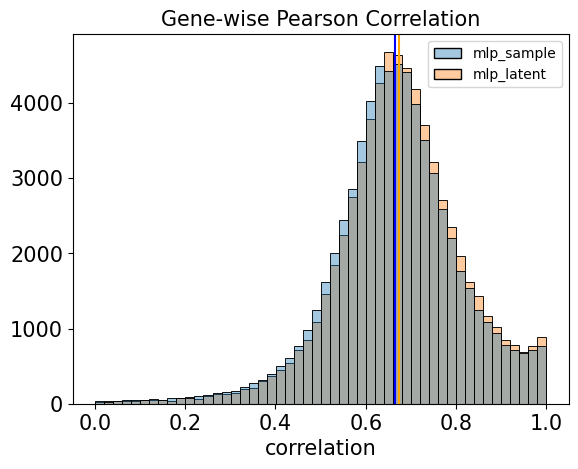

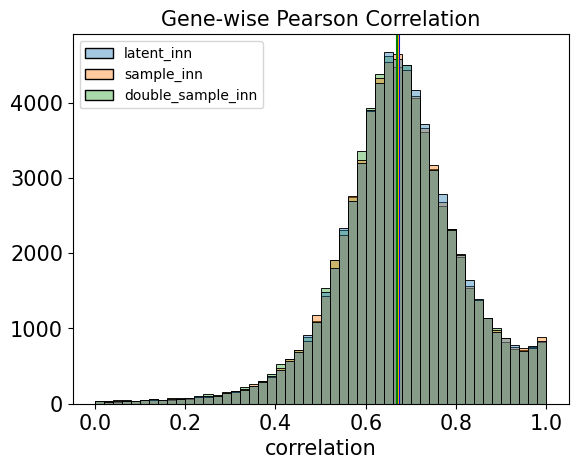

In [23]:
subset_dict = {key: value for key, value in per_peak_auroc_dict.items() if key in {"mlp_sample", "mlp_latent"}}
corr_histograms(
    subset_dict,
    labels=["MLP Sample", "MLP Latent"],
    alpha=0.4,
    colors=["blue", "orange"],
    bins=50,
    save_figs=save_figs,
    file_name="hist_auroc_mlp"
)


subset_dict = {key: value for key, value in per_peak_auroc_dict.items() if key not in {"mlp_sample", "mlp_latent"}}
corr_histograms(
    subset_dict,
    labels=["MLP Sample", "MLP Latent"],
    alpha=0.4,
    colors=["blue", "orange", "green"],
    bins=50,
    save_figs=save_figs,
    file_name="hist_auroc_cNF"
)

In [25]:
#compare_correlations(x=per_peak_auroc_dict["mlp_sample"], y=per_peak_auroc_dict["mlp_latent"], title=f"Peak-wise AUROC", x_label="MLP Sample", y_label="MLP Latent", save_fig=save_figs, file_name="auroc_mlp_latent_sample.pdf")
#compare_correlations(x=per_peak_auroc_dict["sample_inn"], y=per_peak_auroc_dict["latent_inn"], title=f"Peak-wise AUROC", x_label="cNF Sample", y_label="cNF Latent", save_fig=save_figs, file_name="auroc_cNF_latent_sample.pdf")
#compare_correlations(x=per_peak_auroc_dict["sample_inn"], y=per_peak_auroc_dict["double_sample_inn"], title=f"Peak-wise AUROC", x_label="cNF Sample", y_label="cNF Double-Sample", save_fig=save_figs, file_name="auroc_cNF_sample_doublesample.pdf")
#compare_correlations(x=per_peak_auroc_dict["latent_inn"], y=per_peak_auroc_dict["double_sample_inn"], title=f"Peak-wise AUROC", x_label="cNF Latent", y_label="cNF Double-Sample", save_fig=save_figs, file_name="auroc_cNF_latent_doublesample.pdf")
#compare_correlations(x=per_peak_auroc_dict["mlp_latent"], y=per_peak_auroc_dict["latent_inn"], title=f"Peak-wise AUROC", x_label="MLP Latent", y_label="cNF Sample", save_fig=save_figs, file_name="auroc_mlp_latent_cNF_sample.pdf")
